In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt
import scipy as sc
mpl.rcParams.update({'font.size':22})

# Progress bar yay
from ipywidgets import FloatProgress

# Physical Constants
phi0 = 2.067833831e-15
hbar = 1.054571800e-34
e = 1.6021766208e-19

## Tunable CSFQ with negligible inductance

The tunable capacitively shunted flux qubit (CSFQ) is a four Josephson junction flux qubit where two junction with areas smaller by a factor $\alpha$ form a DC-SQUID. The Hamiltonian for this system can be expressed in the charge basis as

$$\hat{H} = \frac{1}{2}E_\mathrm{C} \hat{n}^2 -2E_\mathrm{J}\cos\left(\hat{\phi}\right) +\alpha E_\mathrm{J}\cos\left(\frac{\phi_x}{2}\right)\cos\left(2\hat{\phi} + \phi_z\right)$$

where $E_\mathrm{C}$ and $E_\mathrm{J}$ are the charging and Josephson energies respectively and $\phi_x$ and $\phi_z$ are the external phases applied to the X and Z loops of the CSFQ respectively. $\hat{n}$ is Cooper pair number operator and $\hat{\phi}$ is the phase operator.

In the charge basis the operators can be expressed as

$$\hat{n} = \hat{a}\hat{a}^\dagger$$

where $\hat{a}$ is the creation operator.

The phase operators can be expressed as

$$\cos\left(\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} \hat{D} + e^{-j\phi_e} \hat{D}^\dagger \right)$$

where $\hat{D}$ is the charge raising operator which has the property

$$\hat{D} |n\rangle = |n+1\rangle$$

The last term in the Hamiltonian is written as

$$\cos\left(2\hat{\phi}+\phi_e\right) = \frac{1}{2}\left( e^{j\phi_e} {\hat{D}}^2 + e^{-j\phi_e} {\hat{D}^{\dagger 2}} \right)$$

in terms of the defined operators. The charge raising operator can be defined in qutip by building the operator with the charge (Fock) states:

$$\hat{D} = \sum_{n=0}^{N-1}|n\rangle\langle n+1|$$

With these definitions it is possible to diagonalise the Hamiltonian and find the energy eigenvalues and eigenstates.

#### Hamiltonian Definition:

In [3]:
# CSFQ parameters
Jc = 3 # uA/um^2
Ca = 60 # fF/um^2
Ajj = 0.2*0.2 # um^2, 2 JJs worth
Csh = 105e-15 # Shunting capacitor
alpha = 1.0

#
# CSFQ Class
#
class CSFQ_Qubit:
    
    # Required parameters (keys)
    params_required = ["Jc",# Critical current density (FAB)
                       "Ca",# Capacitance density (FAB)
                       "Ajj",# Large junction area
                       "Csh",# Shunt capacitance
                       "alpha",# Ratio of small to large JJ area
                       "trunc"# Operator truncation
                      ]
    
    # Optional parameters (keys)
    params_optional = ["Cs" # Stray capacitance
                      ]
    
    # External parameters
    params_ext = ["phi_x",
                  "phi_z"
                 ]
    
    # Energy units
    units_energy = ["J", # Joules
                    "GHz" # GHz
                   ]
    
    # Parameter sweep output options
    sweep_output = ["E", # Eigenenergies only
                    "EandS" # Eigenenergies and states
                   ]
    
    # Initialisation
    def __init__(self,csfq_params):
        
        # Update required parameters
        if csfq_params:
            missing = []
            for key in CSFQ_Qubit.params_required:
                if key not in list(csfq_params.keys()):
                    missing.append(key)
            if missing != []:
                raise Exception("Missing parameters in CSFQ parameter list:\n\t %s" % missing)
        else:
            raise Exception("Empty CSFQ parameter list.")
        self.params = csfq_params
        
        # Update optional parameters
        
        # Construct the operators
        self.op_charge_number()
        self.op_charge_raising()
        self.op_charge_lowering()
    
    # Print CSQF information
    def info(self):
        for k in list(self.params.keys()):
            print ("[%s] = %e" % (k,self.params[k]))
        print ("[Csigma] = %e F" % self.get_Csigma())
        print ("[Ec] = %e GHz" % self.get_Ec())
        print ("[Ej (large)] = %e GHz" % self.get_large_Ej())
        print ("[Ej (small)] = %e GHz" % self.get_small_Ej())
        print ("[Ej/Ec] = %.1f\n" % (self.get_small_Ej()/self.get_Ec()))
    
    # Get total capacitance seen by small junction (F)
    def get_Csigma(self):
        
        # Small junction
        Csmall = self.params["alpha"]*self.params["Ajj"]*self.params["Ca"]*1e-15 + self.params["Csh"]
        
        # Large junctions (in series)
        Clarge = 0.5*self.params["Ajj"]*self.params["Ca"]*1e-15
        
        return Csmall + Clarge
    
    # Get small junction energy (J)
    def get_small_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["alpha"]*self.params["Ajj"]*self.params["Jc"]*phi0/(4*np.pi**2*hbar) * 1e-15
    
    # Get large junction energy (J)
    def get_large_Ej(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy.")
        if unit == "J":
            return self.params["Ajj"]*self.params["Jc"]*phi0/(2*np.pi) * 1e-6
        elif unit == "GHz":
            return self.params["Ajj"]*self.params["Jc"]*phi0/(4*np.pi**2*hbar) * 1e-15
    
    # Get charging energy seen by small junctions
    def get_Ec(self,unit="GHz"):
        if unit not in CSFQ_Qubit.units_energy:
            raise Exception("Unrecognized unit of energy '%s'." % unit)
        if unit == "J":
            return 2*e**2/self.get_Csigma()
        elif unit == "GHz":
            return 2*e**2/(self.get_Csigma()*2*np.pi*hbar) * 1e-9
    
    # Create charge operator
    def op_charge_number(self):
        if hasattr(self,"op_n"):
            return self.op_n
        else:
            self.op_n = qt.num(self.params["trunc"],-(self.params["trunc"] - 1)/2)
    
    # Create charge raising operator
    def op_charge_raising(self):
        if hasattr(self,"op_Dp"):
            return self.op_Dp
        else:
            self.op_Dp = qt.qeye(self.params["trunc"]) - qt.qeye(self.params["trunc"])
            for i in range(self.params["trunc"]-1):
                self.op_Dp += qt.basis(self.params["trunc"],i)*qt.basis(self.params["trunc"],i+1).dag()
    
    # Create charge lowering operator
    def op_charge_lowering(self):
        if hasattr(self,"op_Dm"):
            return self.op_Dm
        else:
            if not hasattr(self,"op_Dp"):
                raise Exception("Define the raising operator first.")
            else:
                self.op_Dm = self.op_Dp.dag()
    
    # Create phase operator
    def op_phase(self):
        
        # Still need to find a way to express natively in qutip
        pass
    
    # Get Hamiltonian operator
    def op_hamiltonian(self,phi_x,phi_z):
        
        # Always update
        self.op_H = 0.5*self.get_Ec()*self.op_n**2 - \
        self.get_large_Ej()*(self.op_Dp+self.op_Dm) + \
        0.5*self.get_small_Ej()*np.cos(phi_x/2)*(np.exp(1j*phi_z)*self.op_Dp**2+np.exp(-1j*phi_z)*self.op_Dm**2)
    
    # External parameter sweep sub function
    def param_sweep_ext(self,param,ext_vars,sweep_var,output="E",ipy_pbar=True):
        
        # Empty the result variable
        self.sweep_result = []
        
        # Check if using ipython progress bar
        if ipy_pbar:
            
            # Setup progress bar
            f = FloatProgress(min=0, max=len(sweep_var))
            print("'%s' sweep progress:" % param)
            display(f)
            
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                        f.value+=1
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
                        f.value+=1
        else:
            if param == "phi_x":
                if output == "EandS":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_x in sweep_var:
                        self.op_hamiltonian(phi_x,ext_vars[0])
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
            if param == "phi_z":
                if output == "EandS":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        self.sweep_result.append(self.op_H.eigenstates())
                elif output == "E":
                    for phi_z in sweep_var:
                        self.op_hamiltonian(ext_vars[0],phi_z)
                        E,S = self.op_H.eigenstates()
                        self.sweep_result.append(E)
        
        # Return result in suitable format
        self.sweep_result = np.array(self.sweep_result).T
        return (sweep_var,self.sweep_result)
    
    # Static linear parameter sweep
    def param_sweep_lin(self,param,ext_vars,start,end,num,overwrite=False,output="E",ipy_pbar=True):
        
        if output not in CSFQ_Qubit.sweep_output:
            raise Exception("Unrecognised sweep output option '%s'." % output)
        
        if param not in CSFQ_Qubit.params_ext and param not in CSFQ_Qubit.params_required and param not in CSFQ_Qubit.params_optional:
            raise Exception("Unrecognised sweep parameter '%s'." % param)
        
        if not overwrite:
            if hasattr(self,"sweep_result"):
                raise Exception("Not overwritting existing sweep_result.")
        
        # Create the parameter sweep array
        sweep_var = np.linspace(start,end,num)
        
        # Perform sweep on desired external parameter
        if param in CSFQ_Qubit.params_ext:
            return self.param_sweep_ext(param,ext_vars,sweep_var,output=output,ipy_pbar=ipy_pbar)
        
        # Perform sweep on desired internal parameter
        # TODO
        elif param in CSFQ_Qubit.params_required:
            pass
        
    # Perturbative mapping to Pauli coefficients
    def get_AB_perturbative(self,phi_x,phi_z):
        
        # Get the first two state vectors from Hamiltonian diagonalised at phi_z = 0
        self.op_hamiltonian(phi_x,0.0)
        Ei,states = self.op_H.eigenstates()
        gs = states[0]
        es = states[1]

        # Projection
        ex = (gs.dag()*(self.op_Dm**2 - self.op_Dp**2)*es)[0][0]
        Ip = 2*np.pi/phi0*self.get_small_Ej(unit="J")*np.abs(np.cos(phi_x/2)*ex)[0]
        #print (Ip)
        # Coefficients
        A = 0.5*(Ei[1] - Ei[0])
        B = phi0*Ip*phi_z/(4*np.pi**2*hbar)*1e-9
        return (A,B)
    
    # Mapping to 2-level system
    def get_AB(self,phi_x,phi_z,method="pert"):
        if method == "pert":
            return self.get_AB_perturbative(phi_x,phi_z)
    
    # Find optimal flux values for start and end of schedules
    def optimise_flux_schedules(self,Amax,Bmax,method="pert",xmin=0.0):
        
        # Root finding callbacks
        def startx(x):
            A,B = self.get_AB(x[0],0,method=method)
            return [A-Amax]
        def endz(z):
            A,B = self.get_AB(xmin,z[0],method=method)
            return [B-Bmax]
        
        # Get A flux
        retA = sc.optimize.root(startx,[0.9*np.pi])
        if not retA.success:
            raise Exception("Not converged: %s" % retA.message)
        
        # Get A flux
        retB = sc.optimize.root(endz,[0.005])
        if not retB.success:
            raise Exception("Not converged: %s" % retB.message)
        
        return (retA.x[0],retB.x[0])



[Ajj] = 7.000000e-02
[alpha] = 8.400000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.000000e-14
[trunc] = 8.000000e+01
[Csigma] = 2.562800e-14 F
[Ec] = 3.023292e+00 GHz
[Ej (large)] = 1.043035e+02 GHz
[Ej (small)] = 8.761497e+01 GHz
[Ej/Ec] = 29.0

[Ajj] = 7.000000e-02
[alpha] = 4.200000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.000000e-14
[trunc] = 8.000000e+01
[Csigma] = 2.386400e-14 F
[Ec] = 3.246770e+00 GHz
[Ej (large)] = 1.043035e+02 GHz
[Ej (small)] = 4.380749e+01 GHz
[Ej/Ec] = 13.5

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

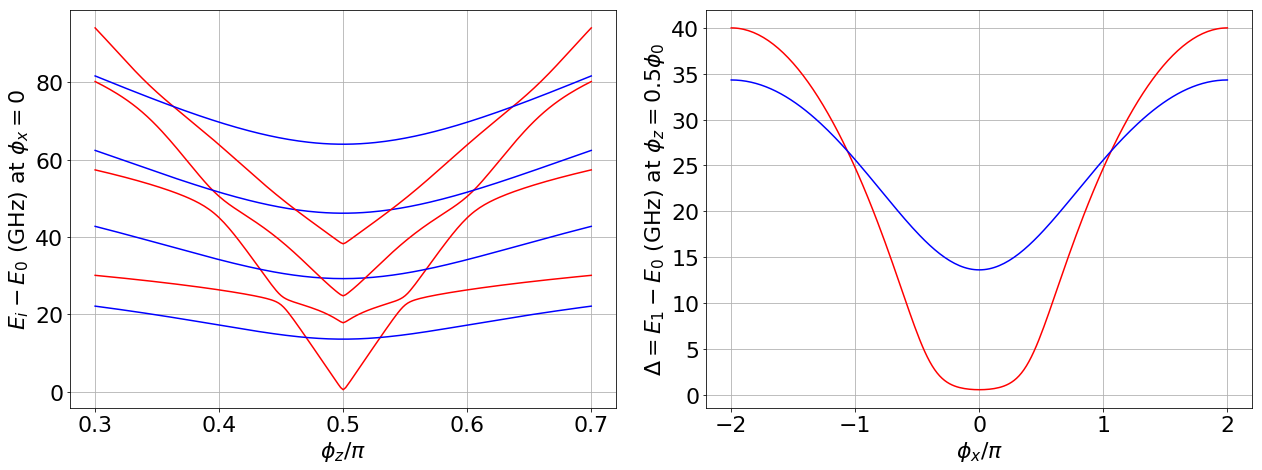

In [5]:
# Create qubits
qubit1_params = {"Ajj":0.07,"alpha":0.84,"Jc":3,"Ca":60,"Csh":20e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

qubit2_params = {"Ajj":0.07,"alpha":0.42,"Jc":3,"Ca":60,"Csh":20e-15,"trunc":80}
qubit2 = CSFQ_Qubit(qubit2_params)
qubit2.info()

# Z Parameter sweep
phi_x = 0.0
z_pts1,Ez_pts1 = qubit1.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)
z_pts2,Ez_pts2 = qubit2.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)

# X Parameter sweep
phi_z = 0.0
x_pts1,Ex_pts1 = qubit1.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)
x_pts2,Ex_pts2 = qubit2.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)

# Plot CSFQ energy levels
fig = plt.figure(figsize=(18,7))

ax1 = plt.subplot(121)
for i in range(4):
    ax1.plot(z_pts1/np.pi+0.5, Ez_pts1[i+1]-Ez_pts1[0],"r-")
    ax1.plot(z_pts2/np.pi+0.5, Ez_pts2[i+1]-Ez_pts2[0],"b-")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
ax1.grid()

ax2 = plt.subplot(122)
ax2.plot(x_pts1/np.pi, Ex_pts1[1]-Ex_pts1[0],"r-")
ax2.plot(x_pts2/np.pi, Ex_pts2[1]-Ex_pts2[0],"b-")
ax2.set_xlabel('$\phi_x/\pi$')
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$')
ax2.grid()

fig.tight_layout()

[Ajj] = 7.200000e-02
[alpha] = 8.400000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.257888e-13 F
[Ec] = 3.431566e-01 GHz
[Ej (large)] = 1.072836e+02 GHz
[Ej (small)] = 9.011826e+01 GHz
[Ej/Ec] = 262.6

[Ajj] = 7.200000e-02
[alpha] = 4.200000e-01
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.239744e-13 F
[Ec] = 3.459365e-01 GHz
[Ej (large)] = 1.072836e+02 GHz
[Ej (small)] = 4.505913e+01 GHz
[Ej/Ec] = 130.3

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

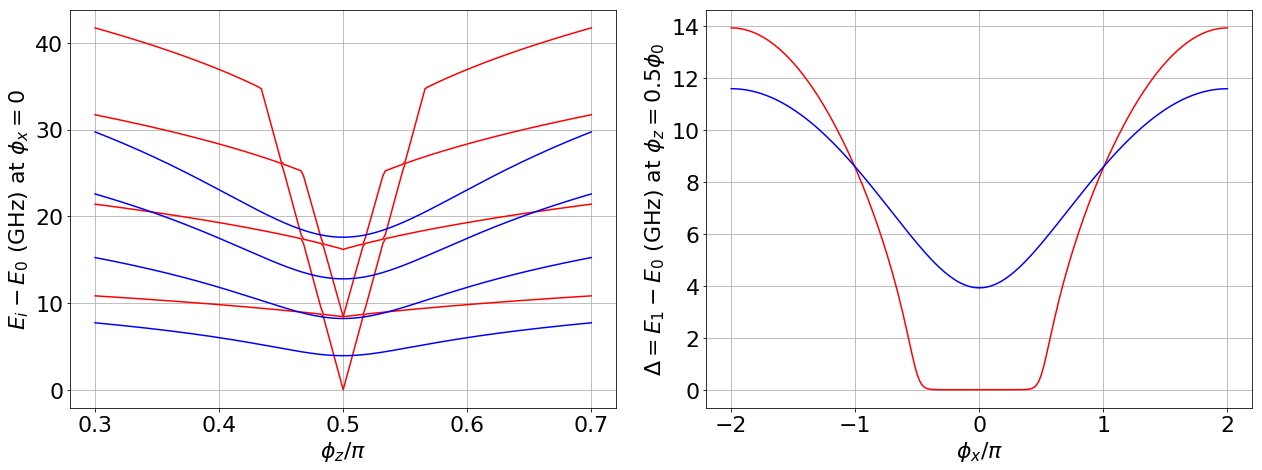

In [13]:
# Create qubits
qubit1_params = {"Ajj":0.36*0.2,"alpha":0.84,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

qubit2_params = {"Ajj":0.36*0.2,"alpha":0.42,"Jc":3,"Ca":60,"Csh":220e-15,"trunc":80}
qubit2 = CSFQ_Qubit(qubit2_params)
qubit2.info()

# Z Parameter sweep
phi_x = 0.0
z_pts1,Ez_pts1 = qubit1.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)
z_pts2,Ez_pts2 = qubit2.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)

# X Parameter sweep
phi_z = 0.0
x_pts1,Ex_pts1 = qubit1.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)
x_pts2,Ex_pts2 = qubit2.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)

# Plot CSFQ energy levels
fig = plt.figure(figsize=(18,7))

ax1 = plt.subplot(121)
for i in range(4):
    ax1.plot(z_pts1/np.pi+0.5, Ez_pts1[i+1]-Ez_pts1[0],"r-")
    ax1.plot(z_pts2/np.pi+0.5, Ez_pts2[i+1]-Ez_pts2[0],"b-")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
ax1.grid()

ax2 = plt.subplot(122)
ax2.plot(x_pts1/np.pi, Ex_pts1[1]-Ex_pts1[0],"r-")
ax2.plot(x_pts2/np.pi, Ex_pts2[1]-Ex_pts2[0],"b-")
ax2.set_xlabel('$\phi_x/\pi$')
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$')
ax2.grid()

fig.tight_layout()

[Ajj] = 7.200000e-02
[alpha] = 9.000000e-01
[Jc] = 2.400000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.260480e-13 F
[Ec] = 3.427631e-01 GHz
[Ej (large)] = 8.582691e+01 GHz
[Ej (small)] = 7.724422e+01 GHz
[Ej/Ec] = 225.4

[Ajj] = 7.200000e-02
[alpha] = 2.100000e-01
[Jc] = 2.400000e+00
[Ca] = 6.000000e+01
[Csh] = 2.200000e-13
[trunc] = 8.000000e+01
[Csigma] = 2.230672e-13 F
[Ec] = 3.473434e-01 GHz
[Ej (large)] = 8.582691e+01 GHz
[Ej (small)] = 1.802365e+01 GHz
[Ej/Ec] = 51.9

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_z' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

'phi_x' sweep progress:


FloatProgress(value=0.0, max=201.0)

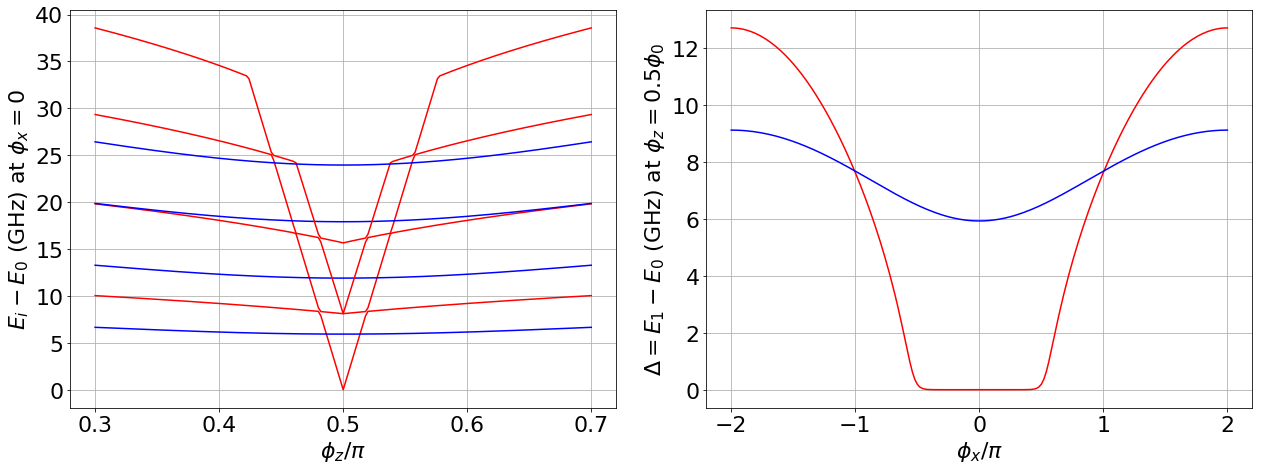

In [14]:
# MIT early CSFQs

# Create qubits
qubit1_params = {"Ajj":0.36*0.2,"alpha":0.9,"Jc":2.4,"Ca":60,"Csh":220e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

qubit2_params = {"Ajj":0.36*0.2,"alpha":0.21,"Jc":2.4,"Ca":60,"Csh":220e-15,"trunc":80}
qubit2 = CSFQ_Qubit(qubit2_params)
qubit2.info()


# Z Parameter sweep
phi_x = 0.0
z_pts1,Ez_pts1 = qubit1.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)
z_pts2,Ez_pts2 = qubit2.param_sweep_lin("phi_z",[phi_x],-0.2*np.pi,0.2*np.pi,201)

# X Parameter sweep
phi_z = 0.0
x_pts1,Ex_pts1 = qubit1.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)
x_pts2,Ex_pts2 = qubit2.param_sweep_lin("phi_x",[phi_z],-2*np.pi,2*np.pi,201,True)

# Plot CSFQ energy levels
fig = plt.figure(figsize=(18,7))

ax1 = plt.subplot(121)
for i in range(4):
    ax1.plot(z_pts1/np.pi+0.5, Ez_pts1[i+1]-Ez_pts1[0],"r-")
    ax1.plot(z_pts2/np.pi+0.5, Ez_pts2[i+1]-Ez_pts2[0],"b-")
ax1.set_xlabel('$\phi_z/\pi$')
ax1.set_ylabel('$E_i-E_0$ (GHz) at $\phi_x = 0$')
ax1.grid()

ax2 = plt.subplot(122)
ax2.plot(x_pts1/np.pi, Ex_pts1[1]-Ex_pts1[0],"r-")
ax2.plot(x_pts2/np.pi, Ex_pts2[1]-Ex_pts2[0],"b-")
ax2.set_xlabel('$\phi_x/\pi$')
ax2.set_ylabel('$\Delta = E_1-E_0$ (GHz) at $\phi_z = 0.5\phi_0$')
ax2.grid()

fig.tight_layout()


In [5]:
# Sinusoidal schedules
def phi_x_sig(t,p):
    if t < 0:
        return p["x_min"]
    elif t >= 0 and t <= p["tan"]:
        return (p["x_max"] - p["x_min"])*np.sin(t/p["tan"]*np.pi) + p["x_min"]
    else:
        return p["x_min"]

def phi_z_sig(t,p):
    if t < 0:
        return p["z_max"]
    elif t >= 0 and t <= p["tan"]:
        return p["z_max"]*(1-np.sin(t/p["tan"]*np.pi))
    else:
        return p["z_max"]

# Optimise the start and end points
phi_x_min = 0.65*np.pi
phi_x_max,phi_z_max = qubit1.optimise_flux_schedules(0.5,0.5,xmin=phi_x_min)

# Get phase points
tan = 10
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
times = np.linspace(-tan,2*tan,201)
phi_x_p = np.array([phi_x_sig(t,p) for t in times])
phi_z_p = np.array([phi_z_sig(t,p) for t in times])

# Get energy points
Apts = []
Bpts = []
for i in range(len(phi_x_p)):
    A,B = qubit1.get_AB_perturbative(phi_x_p[i],phi_z_p[i])
    Apts.append(A)
    Bpts.append(B)
Apts = np.array(Apts)
Bpts = np.array(Bpts)

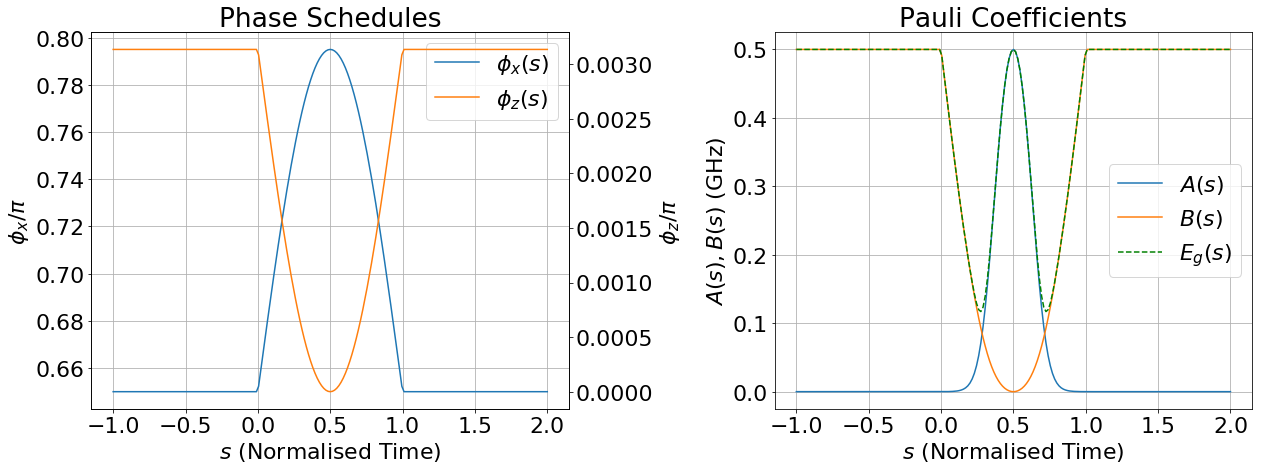

In [6]:
# Phase schedules
fig = plt.figure(figsize=(18,7))
ax11 = plt.subplot(121)
ax11.plot(times/tan, phi_x_p/np.pi,label="$\phi_x(s)$")
ax12 = ax11.twinx()
ax12.plot(times/tan, phi_z_p/np.pi,'C1-',label="$\phi_z(s)$")
ax11.set_title("Phase Schedules")
ax11.set_xlabel('$s$ (Normalised Time)')
ax11.set_ylabel('$\phi_{x}/\pi$')
ax12.set_ylabel('$\phi_{z}/\pi$')
h1,l1 = ax11.get_legend_handles_labels()
h2,l2 = ax12.get_legend_handles_labels()
ax11.legend(h1+h2,l1+l2)
ax11.grid()

# Energy schedules
ax2 = plt.subplot(122)
ax2.plot(times/tan, Apts)
ax2.plot(times/tan, Bpts)
ax2.plot(times/tan,np.sqrt(Apts**2 + Bpts**2),"g--")
ax2.set_title("Pauli Coefficients")
ax2.set_xlabel('$s$ (Normalised Time)')
ax2.set_ylabel('$A(s),B(s)$ (GHz)')
ax2.legend(["$A(s)$","$B(s)$","$E_g(s)$"])
ax2.grid()
fig.tight_layout()

In [7]:
# Create qubit
qubit1_params = {"Ajj":0.2*0.2,"alpha":1,"Jc":3,"Ca":60,"Csh":110e-15,"trunc":80}
qubit1 = CSFQ_Qubit(qubit1_params)
qubit1.info()

# Get the pauli coefficients
def AofS(t,p):
    
    # Values of phase at current time
    phi_x = phi_x_sig(t,p)
    phi_z = phi_z_sig(t,p)
    
    # Get current A
    A,B = qubit1.get_AB_perturbative(phi_x,phi_z)
    return 2*np.pi*A

def BofS(t,p):
    
    # Values of phase at current time
    phi_x = phi_x_sig(t,p)
    phi_z = phi_z_sig(t,p)
    
    # Get current A
    A,B = qubit1.get_AB_perturbative(phi_x,phi_z)
    return 2*np.pi*B

# Range of annealing times
tf_min = 0.0
tf_max = 15.0
tf = np.linspace(tf_min,tf_max,100)

# Hamiltonian at t=0
tan = 1
p = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
H0 = AofS(0,p)*qt.sigmax() + BofS(0,p)*qt.sigmaz()

# Get the ground state at t=0 with eigenvalue E0
Ei,psi_i = H0.eigenstates()
E0 = Ei[0]
psi0 = psi_i[0]

# Single half spin annealing Hamiltonian
# Using qutips functional time dependence array structure
# A(t)sigma_x + B(t)sigma_z
H = [[qt.sigmax(),AofS],[qt.sigmaz(),BofS]]

# Operator states
sz,zstates=qt.sigmaz().eigenstates()
sy,ystates=qt.sigmay().eigenstates()
sx,xstates=qt.sigmax().eigenstates()

# Setup progress bar
f = FloatProgress(min=0, max=len(tf))
print("'tan' sweep progress:")
display(f)

# Use the Lindblad master equation solver
pop0_zdm1 = []
pop0_ydm1 = []
pop0_xdm1 = []
for tan in tf:
    times = np.array([0.0,tan])
    
    # A and B arguments
    argss = {"tan":tan,"x_max":phi_x_max,"x_min":phi_x_min,"z_max":phi_z_max}
    
    # Use time dependent Hamiltonian and specify initial state
    # Unitary evolution: No dissipation. qt.sigmaz()
    result = qt.mesolve(H, psi0, times, [], [], args=argss)
    
    # Save relevant results
    #pop0 = np.append(pop0,[qt.expect(qt.ket2dm(states[0]),result.states[-1])])
    pop0_zdm1.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))
    pop0_ydm1.append(qt.expect(qt.ket2dm(ystates[0]),result.states[1]))
    pop0_xdm1.append(qt.expect(qt.ket2dm(xstates[0]),result.states[1]))
    f.value+=1

[Ajj] = 4.000000e-02
[alpha] = 1.000000e+00
[Jc] = 3.000000e+00
[Ca] = 6.000000e+01
[Csh] = 1.100000e-13
[trunc] = 8.000000e+01
[Csigma] = 1.136000e-13 F
[Ec] = 6.820503e-01 GHz
[Ej] = 5.960202e+01 GHz
[Ej/Ec] = 87.4
'tan' sweep progress:


FloatProgress(value=0.0)

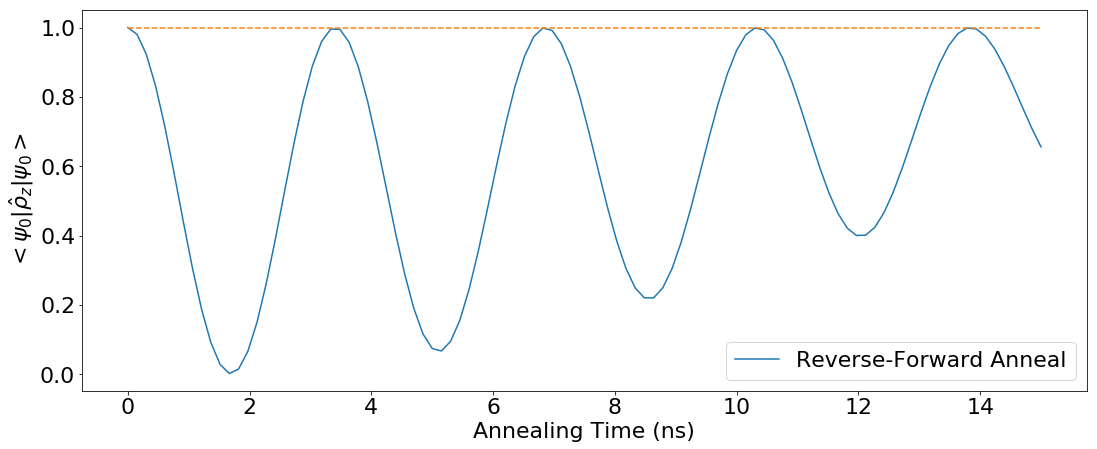

In [8]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(18,7))

# Oscillations
ax2 = plt.subplot(111)
ax2.plot(tf, pop0_zdm1)
ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('Annealing Time (ns)')
ax2.set_ylabel('$<\psi_0|\hat{\\rho}_z|\psi_0>$')
ax2.legend(["Reverse-Forward Anneal"])

In [10]:
# Hamiltonian parameters
delta0 = 0.24*np.pi
epsilon0 = np.pi*0
Arf = 1.0*np.pi
omega = np.pi

# Time dependent energy terms
def epsilon(t,p):
    return p["e0"] + p["Arf"]*np.cos(p["w"]*t)
def delta(t,p):
    return p["d0"]+0*t

# Params
p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}

# To express the result
sz,zstates=qt.sigmaz().eigenstates()

# Solve
delta_vals = [0.24*np.pi,0.48*np.pi,0.72*np.pi,0.96*np.pi]
tan_vals = np.linspace(0.001,15,200)
ypts = []

f = FloatProgress(min=0, max=100)
print ("Progress:")
display(f)
pb_d = 100.0/(len(tan_vals)*len(delta_vals))
for delta0 in delta_vals:
    ypts_t = []
    for tan in tan_vals:
        
        # Get drive frequency
        omega = 2*np.pi/tan
        
        # Initial hamiltonian
        p={"e0":epsilon0,"Arf":Arf,"w":omega,"d0":delta0}
        H0 = 0.5*(delta(0,p)*qt.sigmax() + epsilon(0,p)*qt.sigmaz())

        # Initial state
        Ei,psi_i = H0.eigenstates()
        E0 = Ei[0]
        psi0 = psi_i[0]

        # Hamiltonian definition
        H = [[0.5*qt.sigmax(),delta],[0.5*qt.sigmaz(),epsilon]]

        # Solve time evolution for t >> 2pi/omega
        times = np.array([0,tan])
        result = qt.mesolve(H, psi0, times, [], [], args=p,options=qt.Options(nsteps=7000))

        # Format data (get excited state probability)
        ypts_t.append(qt.expect(qt.ket2dm(zstates[0]),result.states[1]))

        # Update progress bar
        f.value += pb_d
    ypts.append(ypts_t)

Progress:


FloatProgress(value=0.0)

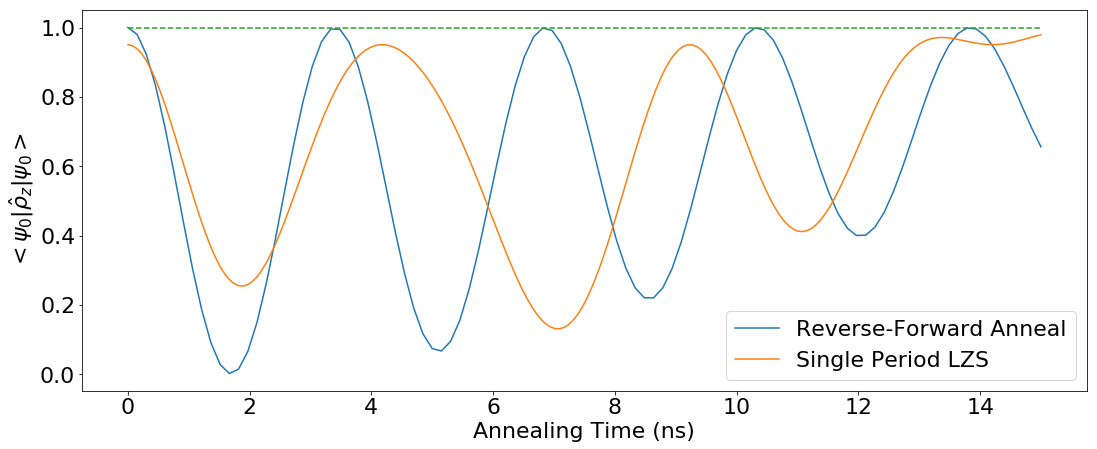

In [11]:
# Plot annealing schedule and oscillations of z expectation value
fig = plt.figure(figsize=(18,7))

# Oscillations
ax2 = plt.subplot(111)
ax2.plot(tf, pop0_zdm1)
ax2.plot(tan_vals,ypts[1])
ax2.plot([0,15],[1.0,1.0],ls="--")
ax2.set_xlabel('Annealing Time (ns)')
ax2.set_ylabel('$<\psi_0|\hat{\\rho}_z|\psi_0>$')
ax2.legend(["Reverse-Forward Anneal","Single Period LZS"])

In [ ]:
def get_phi(qmax):
    # phase operator in charge basis
    phi_hat = np.zeros((2 * qmax + 1, 2 * qmax + 1), dtype=complex)
    for q in range(-qmax, qmax + 1):
        for q_p in range(-qmax, q):
            # phi_hat[q+qmax, q_p+qmax] = 1
            phi_hat[q, q_p] = (qmax * np.sin(
                2 * np.pi * (qmax + 1) * (q - q_p) / (2 * qmax + 1))
                               - (qmax + 1) * np.sin(
                        2 * np.pi * qmax * (q - q_p) / (2 * qmax + 1))
                               ) / (1j * (2 * qmax + 1) ** 2 * (
                        1 - np.cos(2 * np.pi * (q - q_p) / (2 * qmax + 1))))
    phi_hat = phi_hat - phi_hat.T
    return phi_hat * 2 * np.pi

In [ ]:
get_phi(3)

In [ ]:
qt.phase(7,1)/2

In [ ]:
d = {}
print (d.keys())

In [ ]:
d.empty()

In [ ]:
a = np.linspace(0,1,100)

In [ ]:
len(a)